# Company background: Porter is delivery partner for deliveing ordered items from different restaurents to end users. User can book from different channels.



# Problem Statement: Porter want to undertand its orders, deliveries and health of the business. for better user experaince, it wants to build predictive model to estiomate deliverytime  estimate delivery time 

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from category_encoders import one_hot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dropout

In [12]:
df = pd.read_csv('portal.csv', encoding='latin-1')

In [82]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders'],
      dtype='object')

# there is no target data. need to derive it from "actual_delivery_time - created_at"

In [13]:
df.dtypes
#created_at & actual_delivery_time are not in date format. need to change

market_id                   float64
created_at                   object
actual_delivery_time         object
store_id                     object
store_primary_category       object
order_protocol              float64
total_items                   int64
subtotal                      int64
num_distinct_items            int64
min_item_price                int64
max_item_price                int64
total_onshift_partners      float64
total_busy_partners         float64
total_outstanding_orders    float64
dtype: object

# created_at , actual_delivery_time are date columns. need to typecast them. can derive multiple features from it

In [14]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [137]:
df.isnull().sum()/len(df)*100
#total_onshift_partners ,total_busy_partners,total_outstanding_orders equal percentage of missing
#couple of features have null values


market_id                   0.499929
created_at                  0.000000
actual_delivery_time        0.003546
store_id                    0.000000
store_primary_category      2.411006
order_protocol              0.503981
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      8.236927
total_busy_partners         8.236927
total_outstanding_orders    8.236927
dtype: float64

# actual_delivery_time is null in few rows. since target variable will be derived from this column and null values in it leads to target variable null. Also very low rows in this column has ulls.  hence delete rows which have nulls in this column

In [16]:
df["created_at"] = pd.to_datetime(df["created_at"],format='%Y-%m-%d %H:%M:%S')
df["created_at"].describe()
#orders looks like for 4months of data

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6600\1069066098.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["created_at"].describe()


count                  197428
unique                 180985
top       2015-02-11 19:50:43
freq                        6
first     2014-10-19 05:24:15
last      2015-02-18 06:00:44
Name: created_at, dtype: object

In [17]:
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"],format='%Y-%m-%d %H:%M:%S')
df["actual_delivery_time"].describe()
#looks like only 2 months data which is conflicting as per created_date

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6600\3345987898.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["actual_delivery_time"].describe()


count                  197421
unique                 178110
top       2015-02-11 20:40:45
freq                        5
first     2015-01-21 15:58:11
last      2015-02-19 22:45:31
Name: actual_delivery_time, dtype: object

# Observation: created_at have records from 2014. actual_delivery_time have records from 2015. 

# lets derive more featues from date features to investigate further on this observation




In [20]:
df["created_at_year"]=df["created_at"].dt.year
df["actual_delivery_year"]=df["actual_delivery_time"].dt.year
df["created_at_month"]=df["created_at"].dt.month
df["actual_delivery_month"]=df["actual_delivery_time"].dt.month
df["created_at_day"]=df["created_at"].dt.day
df["created_hour"]=df["created_at"].dt.hour
df["created_dayofweek"]=df["created_at"].dt.day_of_week
df["target"]=(df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [21]:
np.sum(df["created_at_year"]==2014)

1

In [22]:
df[df["created_at_year"]==2014]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_busy_partners,total_outstanding_orders,created_at_year,actual_delivery_year,created_at_month,actual_delivery_month,created_at_day,created_hour,created_dayofweek,target
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,675f9820626f5bc0afb47b57890b466e,italian,1.0,1,1695,1,1595,...,NaN,NaN,2014,2015.0,10,1.0,19,5,6,141947.65


# Obseration: only 1 record from 2014 and it got delivered after 3 months. looks this is incorrect record and delete it 

In [23]:
#droping this 1 outlier:
df=df[df["created_at_year"]!=2014]   
df["created_at"].describe()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6600\2676408019.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df["created_at"].describe()


count                  197427
unique                 180984
top       2015-01-24 01:56:33
freq                        6
first     2015-01-21 15:22:03
last      2015-02-18 06:00:44
Name: created_at, dtype: object

# after deleteing 1 record, both created_at and actual_delivery_month dates range are almost similar

In [24]:
df.isnull().sum()/len(df)*100



market_id                   0.499932
created_at                  0.000000
actual_delivery_time        0.003546
store_id                    0.000000
store_primary_category      2.411018
order_protocol              0.503984
total_items                 0.000000
subtotal                    0.000000
num_distinct_items          0.000000
min_item_price              0.000000
max_item_price              0.000000
total_onshift_partners      8.236462
total_busy_partners         8.236462
total_outstanding_orders    8.236462
created_at_year             0.000000
actual_delivery_year        0.003546
created_at_month            0.000000
actual_delivery_month       0.003546
created_at_day              0.000000
created_hour                0.000000
created_dayofweek           0.000000
target                      0.003546
dtype: float64

# Observation: total_onshift_partners, total_busy_partners,total_outstanding_orders are missing at the same time
# couple of features have null values

In [28]:
df_total_null=df[df["total_onshift_partners"].isnull()]
df_total_null.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_busy_partners,total_outstanding_orders,created_at_year,actual_delivery_year,created_at_month,actual_delivery_month,created_at_day,created_hour,created_dayofweek,target
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,2,575,2,225,...,NaN,NaN,2015,2015.0,2,2.0,6,1,4,30.916667
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,5,1415,3,185,...,NaN,NaN,2015,2015.0,2,2.0,14,2,5,69.833333
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,1,650,1,650,...,NaN,NaN,2015,2015.0,1,1.0,31,21,5,57.033333
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,5,1550,5,225,...,NaN,NaN,2015,2015.0,2,2.0,8,3,6,123.200000
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,45d38ce7f5231602e24a2103a0300ae6,breakfast,2.0,6,1110,5,185,...,NaN,NaN,2015,2015.0,1,1.0,23,19,4,56.133333


In [29]:
df_total_null.isnull().sum()/len(df_total_null)*100
#where ever total_onshift_partners is null ,total_busy_partners & total_outstanding_orders  are null and viseversa  

market_id                     0.418178
created_at                    0.000000
actual_delivery_time          0.000000
store_id                      0.000000
store_primary_category        3.351577
order_protocol                0.479675
total_items                   0.000000
subtotal                      0.000000
num_distinct_items            0.000000
min_item_price                0.000000
max_item_price                0.000000
total_onshift_partners      100.000000
total_busy_partners         100.000000
total_outstanding_orders    100.000000
created_at_year               0.000000
actual_delivery_year          0.000000
created_at_month              0.000000
actual_delivery_month         0.000000
created_at_day                0.000000
created_hour                  0.000000
created_dayofweek             0.000000
target                        0.000000
dtype: float64

# lets start missing value treatment

# Market_id is missing in few rows. market_id can be taken from same store_id from other rows as below

In [31]:
#############filling missing values##############
storeMarket={}

def domappeing(row):
    
    if np.invert(np.isnan(row["market_id"])):
        storeMarket[row["store_id"]]=row["market_id"]
    elif row["store_id"] not in storeMarket:
        storeMarket[row["store_id"]]=np.nan
    return None

df.apply(domappeing,axis=1)

counter=0
for k,value in storeMarket.items():
    if np.isnan(value):
        counter+=1
        storeMarket[k]=np.nan
        
        
counter
#33 stores dont have market_id. delete them
df["market_id"]=df.apply(lambda row:row["market_id"] if np.invert(np.isnan(row["market_id"])) else storeMarket[row["store_id"]] ,axis=1)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6600\3806225394.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["market_id"]=df.apply(lambda row:row["market_id"] if np.invert(np.isnan(row["market_id"])) else storeMarket[row["store_id"]] ,axis=1)


#  only 3 rows were missing with market_id after imputation.

In [32]:
df["market_id"].value_counts(dropna=False)

2.0    55352
4.0    47833
1.0    38235
3.0    23412
5.0    18091
6.0    14501
NaN        3
Name: market_id, dtype: int64

# store_primary_category is missing in few rows. 
# store_primary_category can be taken from same store_id from other rows as below

In [33]:
#filling for store primary category

storeCat={}

def domappeing(row):
    
    if type(row["store_primary_category"])==str:
        
        storeCat[row["store_id"]]=row["store_primary_category"]
    elif row["store_id"] not in storeCat:
        storeCat[row["store_id"]]=np.nan
   
    return None

df.apply(domappeing,axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
197423    None
197424    None
197425    None
197426    None
197427    None
Length: 197427, dtype: object

In [34]:
counter=0
for k,value in storeCat.items():
    
    if type(value)!=str:
        counter+=1
print(counter)
        
        

174


In [35]:
#here
print("still nulls",counter)
#33 stores dont have market_id. delete them
df["store_primary_category"]=df.apply(lambda row:row["store_primary_category"] if type(row["store_primary_category"])==str else storeCat[row["store_id"]] ,axis=1)

still nulls 174


C:\Users\lenovo\AppData\Local\Temp\ipykernel_6600\986343664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["store_primary_category"]=df.apply(lambda row:row["store_primary_category"] if type(row["store_primary_category"])==str else storeCat[row["store_id"]] ,axis=1)


# computed for aprox 4000 rows

In [37]:
df["store_primary_category"].value_counts(dropna=False)[np.nan]

867

In [38]:
df=df[np.invert(np.any(df[["market_id","order_protocol","created_at_year","created_at_month","created_at_day","created_hour"]].isna(),axis=1))]

# missing value imputation for total_onshift_partners
# we can estimate this from other rows which are created at same time and market_id etc

In [40]:
total_grouper=df.groupby(by=["market_id","order_protocol","created_at_year","created_at_month","created_at_day","created_hour"]).mean()[["total_onshift_partners","total_busy_partners","total_outstanding_orders"]]
def getonshift(row):
    market_id=row["market_id"]
    order_protocol=row["order_protocol"]
    created_at_year=row["created_at_year"]
    created_at_month=row["created_at_month"]
    created_at_day=row["created_at_day"]
    created_hour=row["created_hour"]
    #print(market_id,created_at_year,created_at_month,created_at_day,created_hour)
    return total_grouper.loc[market_id].loc[order_protocol].loc[created_at_year].loc[created_at_month].loc[created_at_day].loc[created_hour]["total_onshift_partners"]

df["total_onshift_partners"]=df.apply(lambda row:row["total_onshift_partners"] if np.invert(np.isnan(row["total_onshift_partners"])) else getonshift(row) ,axis=1)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6600\3700819898.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_grouper=df.groupby(by=["market_id","order_protocol","created_at_year","created_at_month","created_at_day","created_hour"]).mean()[["total_onshift_partners","total_busy_partners","total_outstanding_orders"]]


# missing value imputation for total_busy_partners
# we can estimate this from other rows which are created at same time and market_id etc

In [41]:

def getonshift(row):
    market_id=row["market_id"]
    order_protocol=row["order_protocol"]
    created_at_year=row["created_at_year"]
    created_at_month=row["created_at_month"]
    created_at_day=row["created_at_day"]
    created_hour=row["created_hour"]
    #print(market_id,created_at_year,created_at_month,created_at_day,created_hour)
    return total_grouper.loc[market_id].loc[order_protocol].loc[created_at_year].loc[created_at_month].loc[created_at_day].loc[created_hour]["total_busy_partners"]

df["total_busy_partners"]=df.apply(lambda row:row["total_busy_partners"] if np.invert(np.isnan(row["total_busy_partners"])) else getonshift(row) ,axis=1)

# missing value imputation for total_outstanding_orders
# we can estimate this from other rows which are created at same time and market_id etc

In [43]:

def getonshift(row):
    market_id=row["market_id"]
    order_protocol=row["order_protocol"]
    created_at_year=row["created_at_year"]
    created_at_month=row["created_at_month"]
    created_at_day=row["created_at_day"]
    created_hour=row["created_hour"]
    #print(market_id,created_at_year,created_at_month,created_at_day,created_hour)
    return total_grouper.loc[market_id].loc[order_protocol].loc[created_at_year].loc[created_at_month].loc[created_at_day].loc[created_hour]["total_outstanding_orders"]

df["total_outstanding_orders"]=df.apply(lambda row:row["total_outstanding_orders"] if np.invert(np.isnan(row["total_outstanding_orders"])) else getonshift(row) ,axis=1)

In [51]:
df=df[~df["actual_delivery_time"].isna()]
df.shape

#delete rows where actual_delivery time is missing as considered as label missing

(186970, 22)

# deleting further missing rows as we have enough dataset to train. 

In [52]:
df.dropna(inplace = True)
df.shape

(186970, 22)

# missing value treatment done. 

In [50]:
df.isnull().sum()

market_id                   0
created_at                  0
actual_delivery_time        0
store_id                    0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
created_at_year             0
actual_delivery_year        0
created_at_month            0
actual_delivery_month       0
created_at_day              0
created_hour                0
created_dayofweek           0
target                      0
dtype: int64

# #########completed missing values filling/handling #########

# lets understand data with descriptive analysis

In [246]:
print(df["market_id"].value_counts())


2.0    54941
4.0    47565
1.0    37869
3.0    22968
5.0    17842
6.0     5785
Name: market_id, dtype: int64


# market_id 6 has less no of orders compared ot other markets. 
# busioness can investigate why market 2 has higher orders and replicate the same in market 6 to boost no of orders and increase its business

In [54]:
df["store_primary_category"].describe()

count       186970
unique          73
top       american
freq         19090
Name: store_primary_category, dtype: object

# more orders are comming for american style restaurents start deploying more delivery boys whereever american style restaturents are available to minimise delivery time

In [55]:
df["order_protocol"].value_counts()

1.0    52587
3.0    50389
5.0    43057
2.0    22231
4.0    18002
6.0      685
7.0       19
Name: order_protocol, dtype: int64

# customers are not placing orders from protocol 7. check what went wrong in this pipline

In [56]:
df["total_items"].describe()
#righ skewed. may need outlier treatment

count    186970.000000
mean          3.201904
std           2.665586
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         411.000000
Name: total_items, dtype: float64

In [57]:
df["subtotal"].describe()

count    186970.000000
mean       2693.864572
std        1826.284905
min           0.000000
25%        1415.000000
50%        2220.000000
75%        3400.000000
max       26800.000000
Name: subtotal, dtype: float64

# some orders have subtotal as 0. check whether these orders promotions etcs

In [58]:
df["num_distinct_items"].describe()

count    186970.000000
mean          2.675365
std           1.628964
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: num_distinct_items, dtype: float64

In [59]:
df["target"].describe()

count    186970.000000
mean         47.804402
std          27.217061
min           1.683333
25%          35.133333
50%          44.416667
75%          56.416667
max        6231.316667
Name: target, dtype: float64

# few orders are delivered in 1.6 min. practically not possible. need to investigate on correctness of this data. 
# few orders took 6000+ min which is again needs outlier treatment

In [61]:
df["min_item_price"].describe()

count    186970.000000
mean        685.622234
std         520.774086
min         -86.000000
25%         299.000000
50%         595.000000
75%         945.000000
max       14700.000000
Name: min_item_price, dtype: float64

# min_item_price is negative for few orders. these needs to be corrected. will remove as part of outlier treatment

In [62]:
df["max_item_price"].describe()

count    186970.000000
mean       1160.830053
std         559.122286
min           0.000000
25%         799.000000
50%        1095.000000
75%        1395.000000
max       14700.000000
Name: max_item_price, dtype: float64

# max_item_price IS ZERO FOR FEW ORDERS which needs to be corrected

In [260]:
df["total_onshift_partners"].describe()

count    186970.000000
mean         44.983198
std          34.547129
min          -4.000000
25%          17.000000
50%          37.000000
75%          66.000000
max         171.000000
Name: total_onshift_partners, dtype: float64

# no of delivery boy cant be negative. need to check why so with business. is it left shifted?

In [63]:
df["total_busy_partners"].describe()

count    186970.000000
mean         41.880573
std          32.104265
min          -5.000000
25%          15.000000
50%          35.000000
75%          62.000000
max         154.000000
Name: total_busy_partners, dtype: float64

# no of busy delivery boy cant be negative. need to check why so with business. is it left shifted?

In [262]:
df["total_outstanding_orders"].describe()

count    186970.000000
mean         58.374582
std          52.776002
min          -6.000000
25%          17.000000
50%          41.000000
75%          85.000000
max         285.000000
Name: total_outstanding_orders, dtype: float64

# no of total_outstanding_orders cant be negative. need to check why so with business. is it left shifted?

In [64]:
df["created_hour"].describe()

count    186970.000000
mean          8.424731
std           8.657435
min           0.000000
25%           2.000000
50%           3.000000
75%          19.000000
max          23.000000
Name: created_hour, dtype: float64

In [65]:
df["created_hour"].value_counts()

2     35522
1     27265
3     25474
20    14773
4     14146
19    12850
0     12028
21    10783
22     8274
23     7668
5      6431
18     4716
17     3187
16     2005
6      1276
15      521
14       40
7         9
8         2
Name: created_hour, dtype: int64

# more orders are plased at 2 AM and less orders at 8 AM.check if time is shifted or in correct time zone 
# plan more delivery boys at 2 am.

In [66]:
df["created_dayofweek"].value_counts()

5    32785
6    31812
4    26417
0    25847
3    24298
2    23011
1    22800
Name: created_dayofweek, dtype: int64

# 5th and 6th day of week has more orders placed

In [67]:
df["target"].describe()

count    186970.000000
mean         47.804402
std          27.217061
min           1.683333
25%          35.133333
50%          44.416667
75%          56.416667
max        6231.316667
Name: target, dtype: float64

# lets start graphical univariant analysis

<Axes: xlabel='market_id', ylabel='count'>

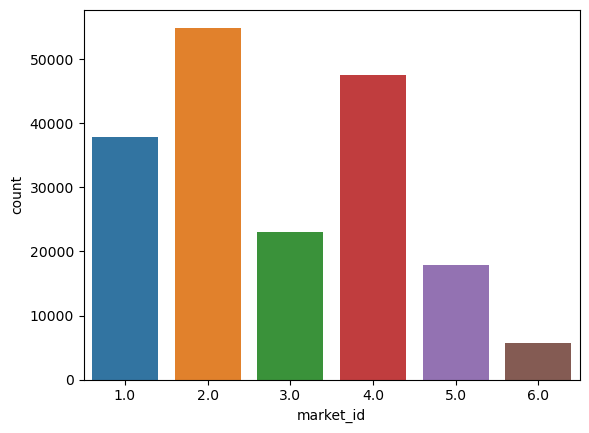

In [69]:
sns.countplot(x="market_id",data=df)

<Axes: xlabel='order_protocol', ylabel='count'>

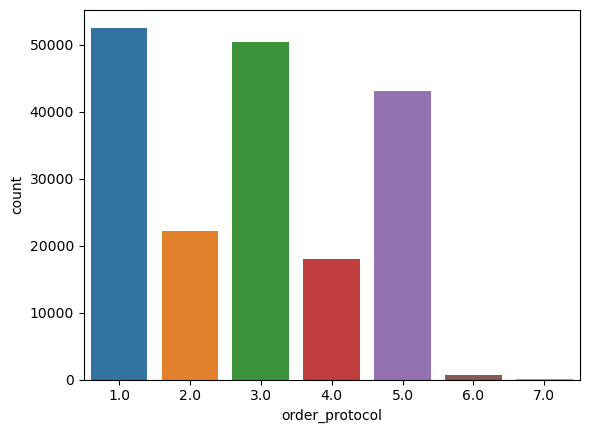

In [70]:
sns.countplot(x="order_protocol",data=df)

<Axes: xlabel='total_items', ylabel='count'>

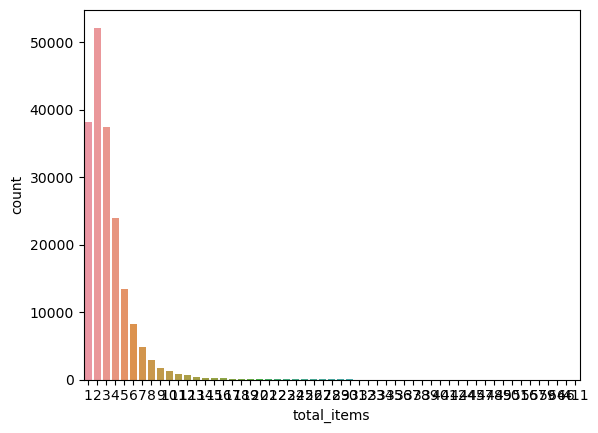

In [71]:
sns.countplot(x="total_items",data=df)

<Axes: xlabel='num_distinct_items', ylabel='count'>

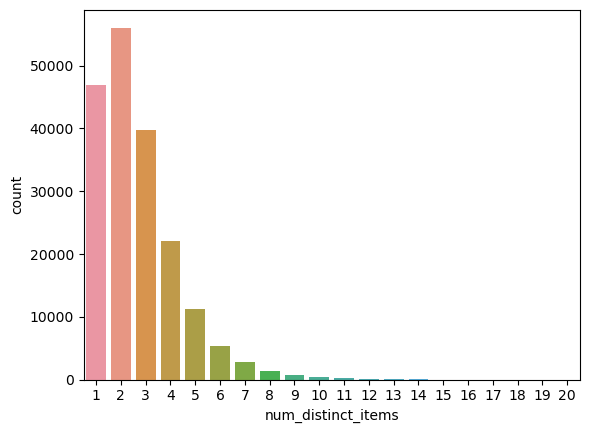

In [294]:
sns.countplot(x="num_distinct_items",data=df)

# num_distinct_items is right skewed. may be log transformation can help medeling performance improve

<Axes: xlabel='order_protocol', ylabel='count'>

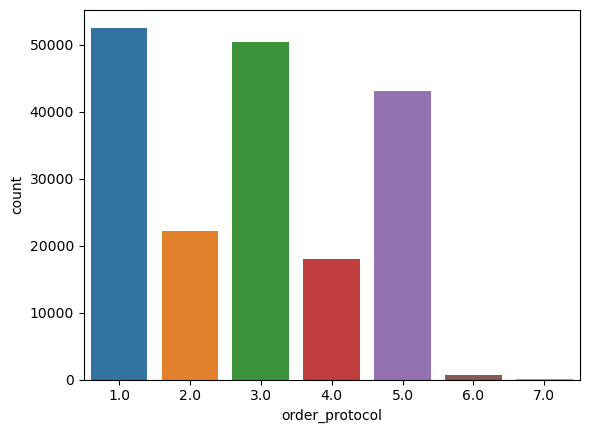

In [72]:
sns.countplot(x="order_protocol",data=df)

# order_protocol 6, 7 are too les. check if deleted rows because of null values belongs to these 6 & 7 protocols

<Axes: xlabel='created_at_month', ylabel='count'>

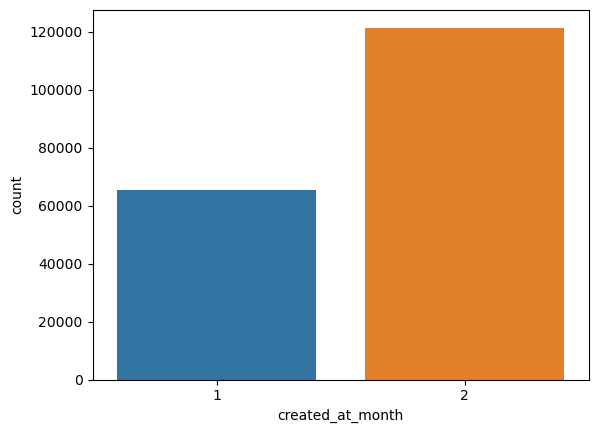

In [73]:
sns.countplot(x="created_at_month",data=df)

# no of orders from 1st month to 2nd month increased/ alomst 100% increase. looks business is gowing at good phase

<Axes: xlabel='created_hour', ylabel='count'>

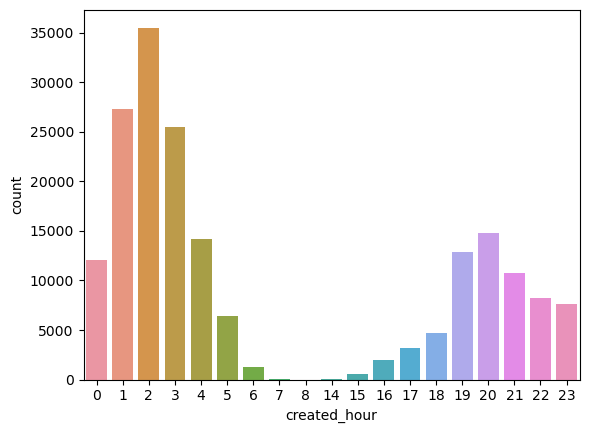

In [76]:
sns.countplot(x="created_hour",data=df)

# created hour looks like bimodel distribution. but it is single model/single peak. it starts from 8am to 8AM next day.

<Axes: xlabel='created_at_day', ylabel='count'>

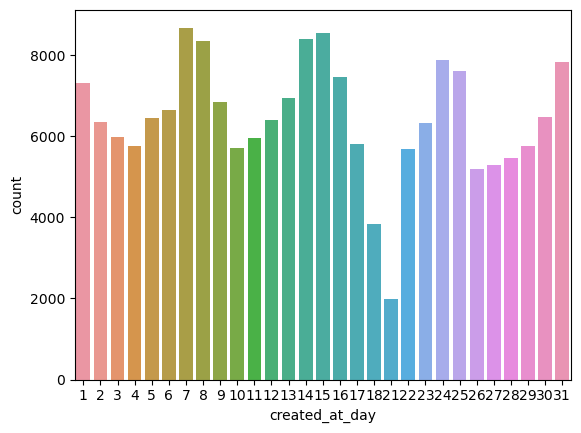

In [299]:
sns.countplot(x="created_at_day",data=df)

# created_at_day ,every 19th,20th day of month dont have any orders created. check what specail these days are with business

# Lets start graphical bivaraite  analysis:


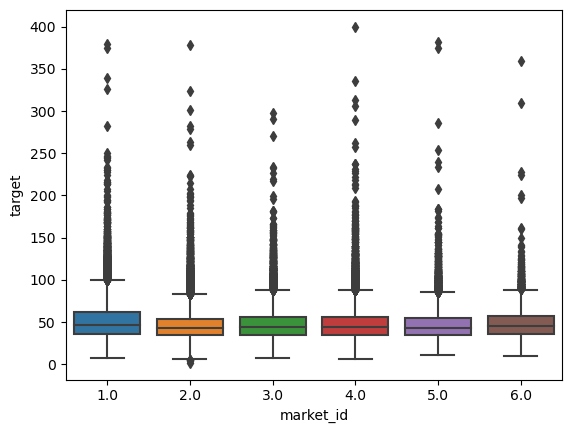

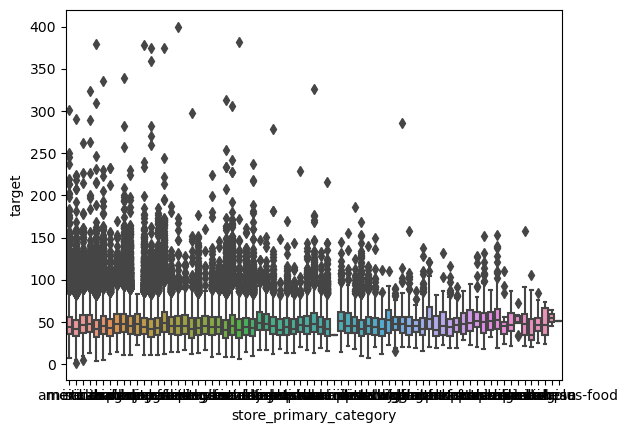

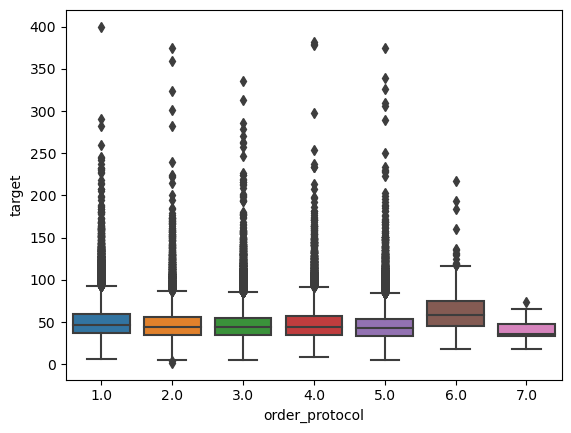

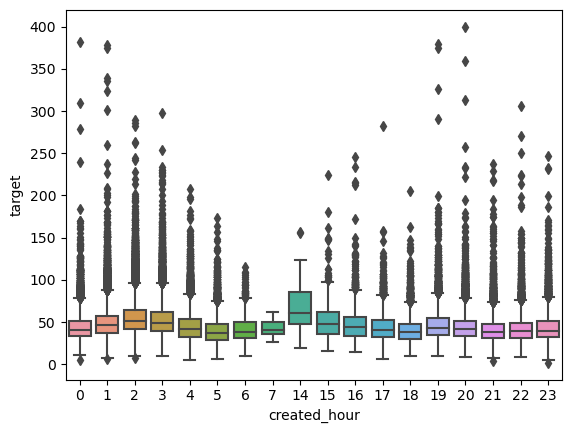

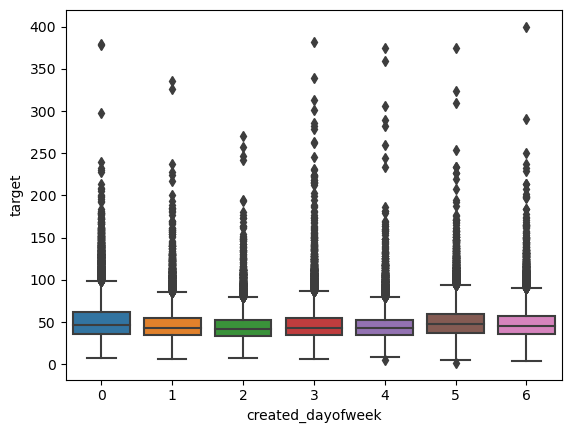

In [77]:
for xvalue in ["market_id","store_primary_category","order_protocol","created_hour","created_dayofweek"]:
    sns.boxplot(x=xvalue, y='target', data=df[df["target"]<400])
    plt.show()

# market_id 1, protocol 6 , 2PM   taking more time to deliver. 

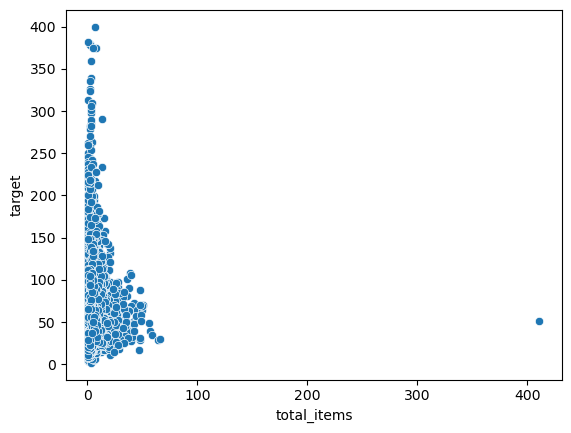

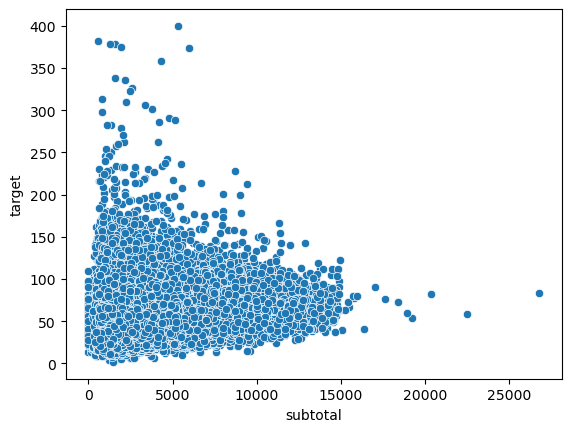

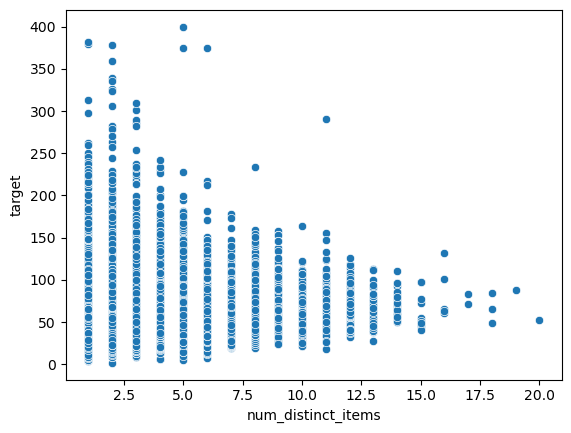

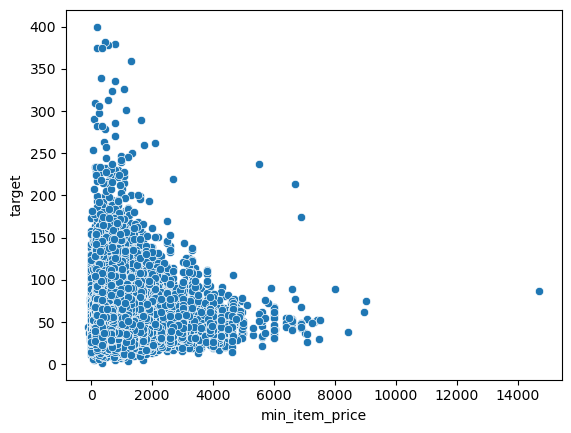

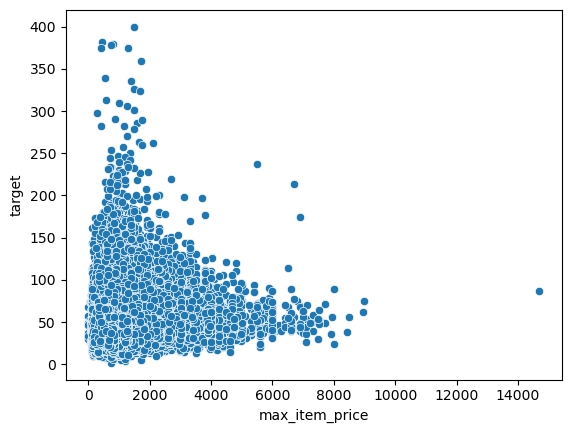

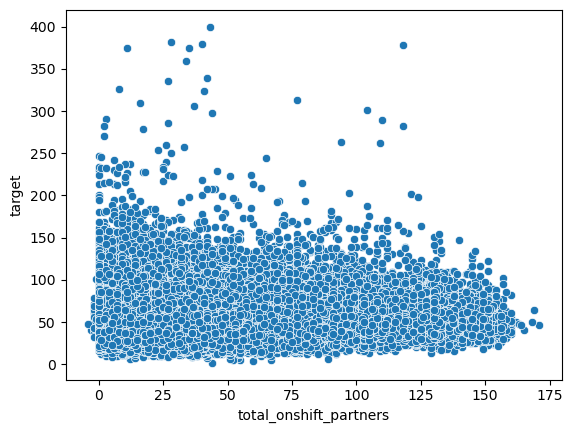

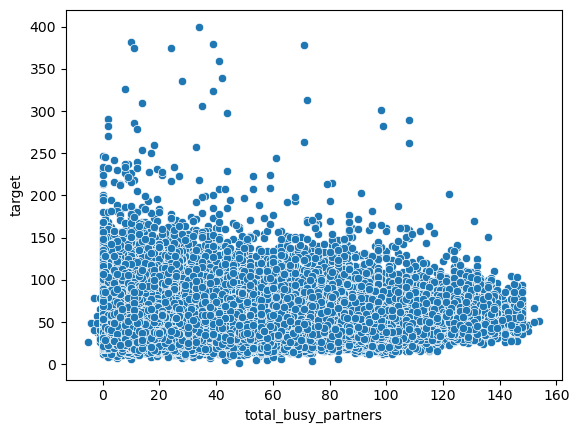

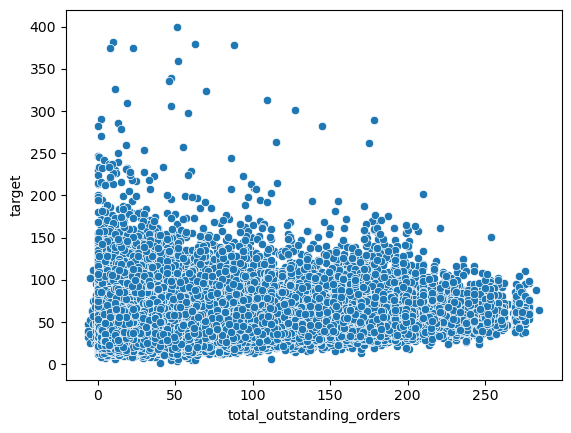

In [79]:
for xvalue in ["total_items","subtotal","num_distinct_items","min_item_price","max_item_price","total_onshift_partners","total_busy_partners","total_outstanding_orders"]:
    sns.scatterplot(x=xvalue, y='target', data=df[df["target"]<400])
    plt.show()

<Axes: >

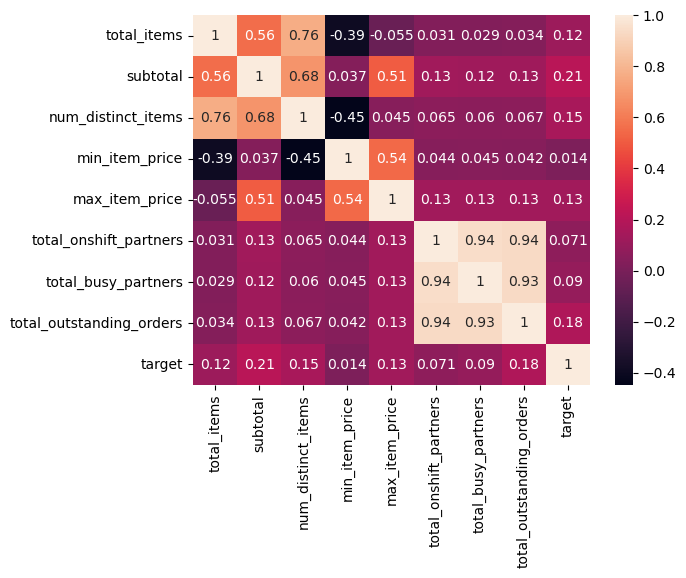

In [80]:
sns.heatmap(df[df["target"]<400][["total_items","subtotal","num_distinct_items","min_item_price","max_item_price","total_onshift_partners","total_busy_partners","total_outstanding_orders","target"]].corr(), annot=True)


<Axes: >

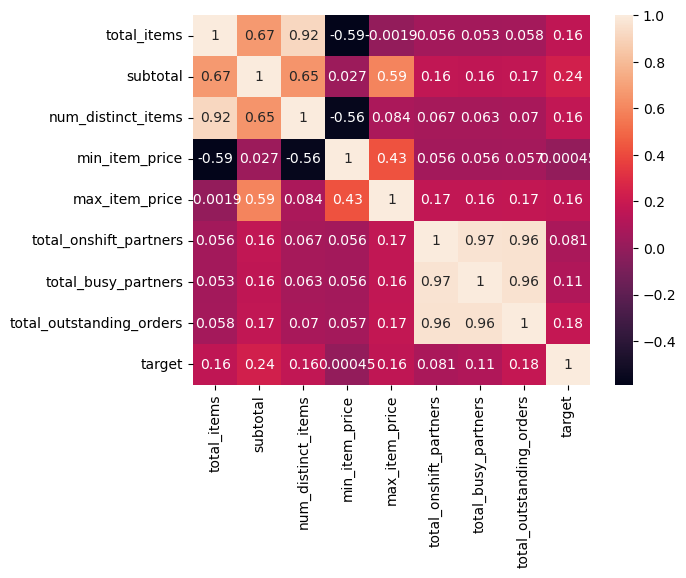

In [81]:
#based on rank correlation
sns.heatmap(df[df["target"]<400][["total_items","subtotal","num_distinct_items","min_item_price","max_item_price","total_onshift_partners","total_busy_partners","total_outstanding_orders","target"]].corr(method="spearman"), annot=True)


# lets start outlier treatment 

<Axes: >

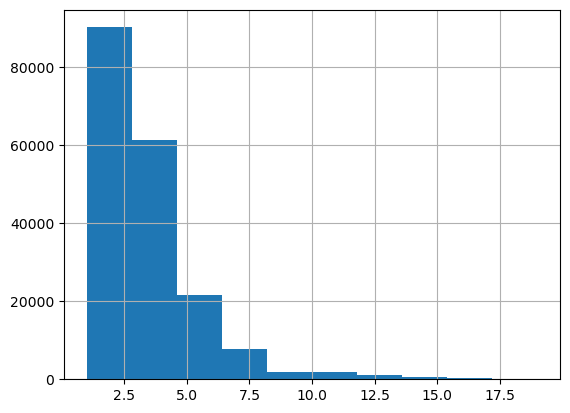

In [82]:
df[df["total_items"]<20]["total_items"].hist()

# total_items is not normal distribtuion. use boxplot to remove outliers or do log transform and see if model performance improved or not

In [83]:
q25,q75=np.percentile(df["total_items"],25),np.percentile(df["total_items"],75)
iqr=q75-q25
cut_off=iqr*1.5
lower,upper=q25-cut_off,q75+cut_off

In [84]:
df=df[(df["total_items"]>=lower) & (df["total_items"]<=upper)] 

In [85]:
df["total_items"].describe()

count    177925.000000
mean          2.810190
std           1.547469
min           1.000000
25%           2.000000
50%           2.000000
75%           4.000000
max           7.000000
Name: total_items, dtype: float64

In [86]:
df=df[df["subtotal"]!=0]

# removed subtotal 0 observations

In [87]:
df["subtotal"].describe()

count    177762.000000
mean       2526.309791
std        1540.137477
min          95.000000
25%        1398.000000
50%        2170.000000
75%        3250.000000
max       15960.000000
Name: subtotal, dtype: float64

<Axes: >

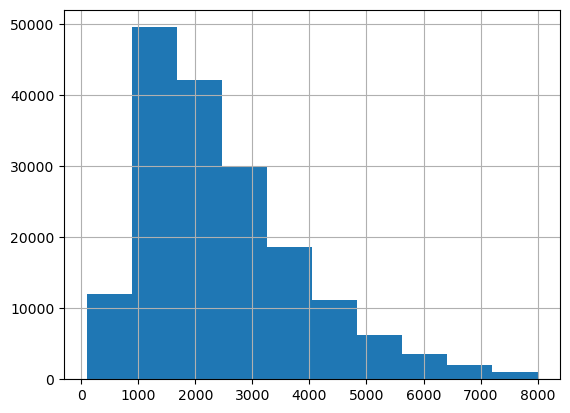

In [89]:
df[df["subtotal"]<8000]["subtotal"].hist()
#subtotal is not normal. use boxplot to remove outlier

In [90]:
q25,q75=np.percentile(df["subtotal"],25),np.percentile(df["subtotal"],75)
iqr=q75-q25
cut_off=iqr*1.5
lower,upper=q25-cut_off,q75+cut_off
df=df[(df["subtotal"]>=lower) & (df["subtotal"]<=upper)]
df["subtotal"].describe()

count    171702.000000
mean       2354.695408
std        1236.479513
min          95.000000
25%        1375.000000
50%        2100.000000
75%        3100.000000
max        6027.000000
Name: subtotal, dtype: float64

In [91]:
df.shape

(171702, 22)

In [94]:
df=df[df["min_item_price"]>0]
q25,q75=np.percentile(df["min_item_price"],25),np.percentile(df["min_item_price"],75)
iqr=q75-q25
cut_off=iqr*1.5
lower,upper=q25-cut_off,q75+cut_off
df=df[(df["min_item_price"]>=lower) & (df["min_item_price"]<=upper)]
df["min_item_price"].describe()

count    165693.000000
mean        653.471100
std         398.362423
min           1.000000
25%         300.000000
50%         599.000000
75%         900.000000
max        1862.000000
Name: min_item_price, dtype: float64

In [95]:

q25,q75=np.percentile(df["max_item_price"],25),np.percentile(df["max_item_price"],75)
iqr=q75-q25
cut_off=iqr*1.5
lower,upper=q25-cut_off,q75+cut_off
df=df[(df["max_item_price"]>=lower) & (df["max_item_price"]<=upper)]
df["max_item_price"].describe()

count    161474.000000
mean       1056.598202
std         370.000565
min          60.000000
25%         799.000000
50%        1025.000000
75%        1299.000000
max        2050.000000
Name: max_item_price, dtype: float64

In [96]:
df["total_onshift_partners"].describe()
#can not be negative
df=df[df["total_onshift_partners"]>=0]


In [97]:

df=df[df["total_busy_partners"]>=0]

In [98]:
#correction of data required as few rows has total_busy_partners >total_onshift_partners
df=df[df["total_onshift_partners"]>=df["total_busy_partners"]]
df["total_busy_partners"].describe()

count    125355.000000
mean         39.226867
std          31.464942
min           0.000000
25%          13.000000
50%          31.000000
75%          60.000000
max         148.000000
Name: total_busy_partners, dtype: float64

# total_busy_partners cant exceed total_onshift_partners. removing those rows

In [99]:
df["total_outstanding_orders"].describe()
df=df[df["total_outstanding_orders"]>=0]


# total_outstanding_orders cant be less than 0. removing those observations

In [100]:
q25,q75=np.percentile(df["target"],25),np.percentile(df["target"],75)
iqr=q75-q25
cut_off=iqr*1.5
lower,upper=q25-cut_off,q75+cut_off
df=df[(df["target"]>=lower) & (df["target"]<=upper)]
df["target"].describe()

count    121332.000000
mean         44.444047
std          14.086276
min           4.950000
25%          34.050000
50%          42.633333
75%          53.183333
max          85.000000
Name: target, dtype: float64

In [34]:
###### outlier treatment completed #################

# lets start modeling the data

In [101]:

X = df.drop(columns=["created_at","actual_delivery_time",'actual_delivery_time',"target"])
y = df['target']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print('Train : ', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)
print('Test  : ', X_test.shape, y_test.shape)

Train :  (77652, 19) (77652,)
Validation: (19413, 19) (19413,)
Test  :  (24267, 19) (24267,)


In [103]:
store_dups=X_train["store_id"].value_counts()
store_dups[store_dups<30]

ca75910166da03ff9d4655a0338e6b09    29
6a83c731660fcc9f14e1ce0b62d45eb9    29
8deb8d1dd92840f975b6931ab3a3c61e    29
32012097fe8ac018cf0586ee96bb9227    29
4a308d84cdd04aa2015bbe13622d5d7c    29
                                    ..
329b389349bbd4ab51e9b50ff0a1a885     1
2ce979e120151e3689bebafd4b1a9f9b     1
ecfb953d9d17e80aa226d13ff9dd04a8     1
847cc55b7032108eee6dd897f3bca8a5     1
197cec18dff201ab4d1966879423f50b     1
Name: store_id, Length: 5075, dtype: int64

In [104]:
store_freq=store_dups[store_dups>=30].to_dict()
X_train["store_freq"]=X_train["store_id"].apply(lambda x: x if x in store_freq else "lowfreq" )
X_val["store_freq"]=X_val["store_id"].apply(lambda x: x if x in store_freq else "lowfreq" )
X_test["store_freq"]=X_test["store_id"].apply(lambda x: x if x in store_freq else "lowfreq" )




# store_id has high cardinality. target encoding is better way to deal. 
# combinning low freq stores as lowfreq to handle new stores in future

In [106]:

X_train.drop(columns=["store_id"],inplace=True)
X_val.drop(columns=["store_id"],inplace=True)
X_test.drop(columns=["store_id"],inplace=True)

In [107]:
X_train["store_primary_category"].value_counts()

american    7778
mexican     7077
pizza       6405
burger      4887
sandwich    4430
            ... 
moroccan       5
african        4
cheese         4
lebanese       2
belgian        1
Name: store_primary_category, Length: 71, dtype: int64

# store_primary_category is high cardinality. hence target encoding is better way to deal

In [108]:
store_cat_freq=X_train["store_primary_category"].value_counts()
store_cat_freq[store_cat_freq<20]


argentine       19
kosher          18
singaporean     14
comfort-food    12
european        10
spanish          7
russian          6
moroccan         5
african          4
cheese           4
lebanese         2
belgian          1
Name: store_primary_category, dtype: int64

In [109]:
store_pcat_freq_dic=store_cat_freq[store_cat_freq>=20].to_dict()
X_train["store_pcat_freq"]=X_train["store_primary_category"].apply(lambda x: x if x in store_pcat_freq_dic else "lowpcatfreq" )
X_val["store_pcat_freq"]=X_val["store_primary_category"].apply(lambda x: x if x in store_pcat_freq_dic else "lowpcatfreq" )
X_test["store_pcat_freq"]=X_test["store_primary_category"].apply(lambda x: x if x in store_pcat_freq_dic else "lowpcatfreq" )


In [110]:
X_train.drop(columns=["store_primary_category"],inplace=True)
X_val.drop(columns=["store_primary_category"],inplace=True)
X_test.drop(columns=["store_primary_category"],inplace=True)

In [112]:

enc = TargetEncoder(cols=["store_freq","store_pcat_freq"])
X_train = enc.fit_transform(X_train, y_train)

X_val = enc.transform(X_val, y_val)
X_test = enc.transform(X_test, y_test)


In [113]:
oh=one_hot.OneHotEncoder(cols=["market_id","order_protocol"])

In [114]:
X_train=oh.fit_transform(X_train)
X_val=oh.transform(X_val)
X_test=oh.transform(X_test)

In [116]:
print('Train : ', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)
print('Test  : ', X_test.shape, y_test.shape)

Train :  (77652, 30) (77652,)
Validation: (19413, 30) (19413,)
Test  :  (24267, 30) (24267,)


In [117]:

rf_model=RandomForestRegressor(n_estimators=10)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10)

In [118]:
rf_model.score(X_train, y_train)

0.8595506325645235

In [ ]:
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [119]:
print("R square for train",rf_model.score(X_train, y_train))
print("R square for val",rf_model.score(X_val, y_val))
print("R square for test",rf_model.score(X_test, y_test))

R square for train 0.8595506325645235
R square for val 0.20276071105117321
R square for test 0.2026505721781079


In [122]:
def MAPE(Y_Predicted,Y_actual):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [123]:
print("train RMSE ",np.sqrt(mean_squared_error(rf_model.predict(X_train),y_train)))
print("val RMSE ",np.sqrt(mean_squared_error(rf_model.predict(X_val),y_val)))
print("test RMSE ",np.sqrt(mean_squared_error(rf_model.predict(X_test),y_test)))

print("train MSE ",mean_squared_error(rf_model.predict(X_train),y_train))
print("val MSE ",mean_squared_error(rf_model.predict(X_val),y_val))
print("test MSE ",mean_squared_error(rf_model.predict(X_test),y_test))

print("train MAE ",mean_absolute_error(rf_model.predict(X_train),y_train))
print("val MAE ",mean_absolute_error(rf_model.predict(X_val),y_val))
print("test MAE ",mean_absolute_error(rf_model.predict(X_test),y_test))


print("train MAPE ",MAPE(rf_model.predict(X_train),y_train))
print("val MAPE ",MAPE(rf_model.predict(X_val),y_val))
print("test MAPE ",MAPE(rf_model.predict(X_test),y_test))

train RMSE  5.274851023557791
val RMSE  12.595255642624583
test RMSE  12.595600508334684
train MSE  27.82405332072868
val MSE  158.64046470306639
test MSE  158.64915216556093
train MAE  3.8957575096952715
val MAE  9.917674835386858
test MAE  9.924055872629955
train MAPE  9.709020589947128
val MAPE  24.726414267285843
test MAPE  24.700655917129414


# randomforest model is overfitting. suffering with high variance problem


# MAE for test is 9.9
# MAPE for test is 25%


In [124]:



# For Reproducibility
np.random.seed(82)
tf.random.set_seed(82)

In [125]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [126]:
def create_baseline():
    model = Sequential([
                        Dense(456, activation="relu",kernel_initializer='glorot_uniform'),
                        Dense(228, activation="relu",kernel_initializer='glorot_uniform'),
                        Dense(128, activation="relu",kernel_initializer='glorot_uniform'),
                        Dense(64, activation="relu",kernel_initializer='glorot_uniform'),
                        Dense(32, activation="relu",kernel_initializer='glorot_uniform'),
                        Dense(1 , activation = 'relu',kernel_initializer='glorot_uniform')])
    return model
    
    

    

model = create_baseline()
model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [127]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val),  epochs=50, batch_size=128, verbose=0)


In [128]:
model.evaluate(X_train, y_train)

2427/2427 [==============================] - 10s 4ms/step - loss: 123.9880 - root_mean_squared_error: 11.1350


[123.98799896240234, 11.134989738464355]

In [129]:
model.evaluate(X_val, y_val)

607/607 [==============================] - 2s 4ms/step - loss: 154.1317 - root_mean_squared_error: 12.4150


[154.13172912597656, 12.414979934692383]

In [130]:
model.evaluate(X_test, y_test)

759/759 [==============================] - 3s 4ms/step - loss: 151.0897 - root_mean_squared_error: 12.2919


[151.08970642089844, 12.291854858398438]

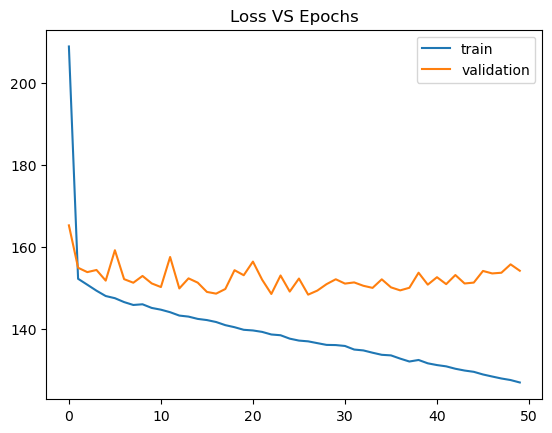

In [131]:
epochs = history.epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()


# compared to random forrest, overfiting is reduced. however it needs eraly stopping 

# lets try with regularization below

In [132]:
def create_baseline():
    # lambda = 0.01
    L2Reg = tf.keras.regularizers.L2(l2=1e-6)
    model = Sequential([
                    Dense(256, activation="relu",kernel_initializer='glorot_uniform', kernel_regularizer = L2Reg ),
                    Dense(128, activation="relu",kernel_initializer='glorot_uniform', kernel_regularizer = L2Reg),
                    Dense(64, activation="relu",kernel_initializer='glorot_uniform', kernel_regularizer = L2Reg),
                    Dense(1 ,kernel_initializer='glorot_uniform', activation = 'relu')])
    return model
model_reg = create_baseline()
model_reg.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [133]:
history_reg = model_reg.fit(X_train, y_train, validation_data = (X_val, y_val),  epochs=10, batch_size=128, verbose=0)
model_reg.evaluate(X_train, y_train)


2427/2427 [==============================] - 8s 3ms/step - loss: 143.7797 - root_mean_squared_error: 11.9908


[143.77969360351562, 11.990799903869629]

In [134]:
model_reg.evaluate(X_val, y_val)

607/607 [==============================] - 2s 4ms/step - loss: 151.5482 - root_mean_squared_error: 12.3105


[151.54815673828125, 12.310474395751953]

In [135]:
model_reg.evaluate(X_test, y_test)

759/759 [==============================] - 3s 3ms/step - loss: 148.7454 - root_mean_squared_error: 12.1961


[148.74539184570312, 12.196104049682617]

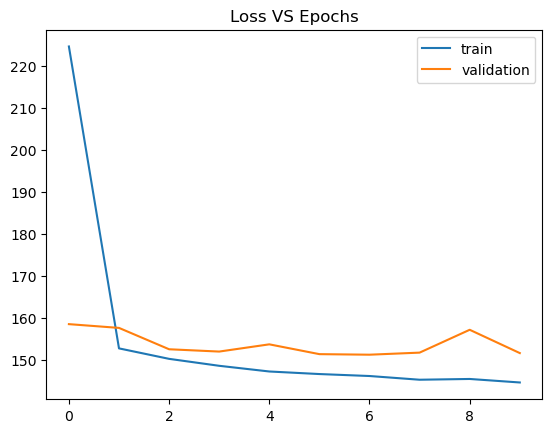

In [136]:
epochs = history_reg.epoch
loss = history_reg.history["loss"]
val_loss = history_reg.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()


# after applying regularization, varaince reduced slightly. but bias increased

In [137]:



def create_BatchNormalization_model():
    L2Reg = tf.keras.regularizers.L2(l2=1e-6)
    model = Sequential([
                    Dense(456, kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dropout(0.2),
                    Dense(256, kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dense(128,kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dense(64,kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dense(1,activation="relu",kernel_initializer='glorot_uniform')])
    return model
model_all = create_BatchNormalization_model()
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode="min", patience=20,  restore_best_weights=True)
ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath='tf_model.h5',
                                                             monitor='val_loss',
                                                             save_best_only=True,
                                                             mode='min')
model_all.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                       tf.keras.metrics.RootMeanSquaredError(),
                      tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)])
history_all = model_all.fit(X_train, y_train, validation_data = (X_val, y_val),  epochs=60, batch_size=128, verbose=1,callbacks=[EarlyStoppingCallback, ModelCheckpointCallback])



Epoch 1/60
604/607 [============================>.] - ETA: 0s - loss: 1141.1093 - mean_squared_error: 1141.1086 - root_mean_squared_error: 33.7803 - mean_absolute_error: 29.6659

C:\Users\lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


607/607 [==============================] - 15s 17ms/step - loss: 1137.6252 - mean_squared_error: 1137.1201 - root_mean_squared_error: 33.7287 - mean_absolute_error: 29.6001 - val_loss: 354.3586 - val_mean_squared_error: 354.3749 - val_root_mean_squared_error: 18.8244 - val_mean_absolute_error: 14.5876
Epoch 2/60
607/607 [==============================] - 8s 13ms/step - loss: 177.3023 - mean_squared_error: 177.2825 - root_mean_squared_error: 13.3155 - mean_absolute_error: 10.3168 - val_loss: 162.2653 - val_mean_squared_error: 162.2584 - val_root_mean_squared_error: 12.7383 - val_mean_absolute_error: 10.2622
Epoch 3/60
607/607 [==============================] - 11s 19ms/step - loss: 150.1672 - mean_squared_error: 150.1659 - root_mean_squared_error: 12.2542 - mean_absolute_error: 9.6757 - val_loss: 152.3093 - val_mean_squared_error: 152.3035 - val_root_mean_squared_error: 12.3413 - val_mean_absolute_error: 9.5984
Epoch 4/60
607/607 [==============================] - 10s 17ms/step - loss: 

607/607 [==============================] - 7s 12ms/step - loss: 136.5558 - mean_squared_error: 136.5532 - root_mean_squared_error: 11.6856 - mean_absolute_error: 9.2069 - val_loss: 145.2969 - val_mean_squared_error: 145.2706 - val_root_mean_squared_error: 12.0538 - val_mean_absolute_error: 9.4598
Epoch 28/60
607/607 [==============================] - 8s 14ms/step - loss: 136.0719 - mean_squared_error: 136.0658 - root_mean_squared_error: 11.6648 - mean_absolute_error: 9.1909 - val_loss: 145.3201 - val_mean_squared_error: 145.3086 - val_root_mean_squared_error: 12.0547 - val_mean_absolute_error: 9.4643
Epoch 29/60
607/607 [==============================] - 7s 12ms/step - loss: 135.9020 - mean_squared_error: 135.8849 - root_mean_squared_error: 11.6575 - mean_absolute_error: 9.1807 - val_loss: 144.9428 - val_mean_squared_error: 144.9204 - val_root_mean_squared_error: 12.0391 - val_mean_absolute_error: 9.5043
Epoch 30/60
607/607 [==============================] - 9s 15ms/step - loss: 135.37

In [138]:
X_train.shape

(77652, 30)

In [140]:
best_model = create_BatchNormalization_model()
best_model.build(input_shape =(None,30))
best_model.load_weights('tf_model.h5')

In [141]:
best_model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                       tf.keras.metrics.RootMeanSquaredError(),
                      tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)])

In [142]:
best_model.evaluate(X_train, y_train)

2427/2427 [==============================] - 11s 4ms/step - loss: 126.9876 - mean_squared_error: 126.9763 - root_mean_squared_error: 11.2687 - mean_absolute_error: 8.8673


[126.98764038085938, 126.97631072998047, 11.268706321716309, 8.867300033569336]

In [143]:
best_model.evaluate(X_val, y_val)

607/607 [==============================] - 2s 4ms/step - loss: 144.5257 - mean_squared_error: 144.5292 - root_mean_squared_error: 12.0217 - mean_absolute_error: 9.4498


[144.52572631835938, 144.5291748046875, 12.021712303161621, 9.449840545654297]

In [144]:
best_model.evaluate(X_test, y_test)

759/759 [==============================] - 3s 4ms/step - loss: 143.1944 - mean_squared_error: 143.0993 - root_mean_squared_error: 11.9662 - mean_absolute_error: 9.4021


[143.19439697265625, 143.0993194580078, 11.966219902038574, 9.40206241607666]

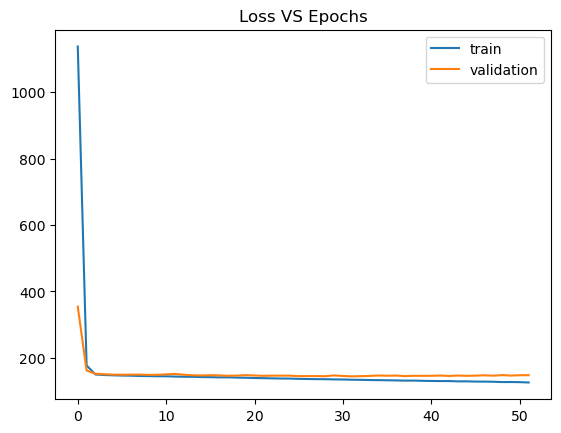

In [145]:
epochs = history_all.epoch
loss = history_all.history["loss"]
val_loss = history_all.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()


In [ ]:
# learning curve is smooth with batch normalization

In [146]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    r_0 = 0.01
    lr = (1/(1+r_0*epoch))*lr
    return lr
    
LRdecay = LearningRateScheduler(scheduler)    



In [147]:



def create_BatchNormalization_LRdecay_model():
    L2Reg = tf.keras.regularizers.L2(l2=1e-6)
    model = Sequential([
                    Dense(456, kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dropout(0.2),
                    Dense(256, kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dense(128,kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dense(64,kernel_regularizer = L2Reg,kernel_initializer='glorot_uniform'),
                    BatchNormalization(),
                    Activation(relu),
                    Dense(1,activation="relu",kernel_initializer='glorot_uniform')])
    return model
model_all = create_BatchNormalization_LRdecay_model()
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode="min", patience=20,  restore_best_weights=True)
ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath='tf_model.h5',
                                                             monitor='val_loss',
                                                             save_best_only=True,
                                                             mode='min')
model_all.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                       tf.keras.metrics.RootMeanSquaredError(),
                      tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)])
history_all = model_all.fit(X_train, y_train, validation_data = (X_val, y_val),  epochs=60, batch_size=128, verbose=1,callbacks=[EarlyStoppingCallback, ModelCheckpointCallback,LRdecay])



Epoch 1/60
607/607 [==============================] - 15s 18ms/step - loss: 1158.0709 - mean_squared_error: 1157.5490 - root_mean_squared_error: 34.0304 - mean_absolute_error: 30.0018 - val_loss: 276.9607 - val_mean_squared_error: 276.9821 - val_root_mean_squared_error: 16.6421 - val_mean_absolute_error: 12.8063 - lr: 0.0010
Epoch 2/60
607/607 [==============================] - 11s 18ms/step - loss: 176.4635 - mean_squared_error: 176.4414 - root_mean_squared_error: 13.2839 - mean_absolute_error: 10.3118 - val_loss: 155.0443 - val_mean_squared_error: 155.0373 - val_root_mean_squared_error: 12.4516 - val_mean_absolute_error: 9.9083 - lr: 9.9010e-04
Epoch 3/60
607/607 [==============================] - 8s 13ms/step - loss: 150.3270 - mean_squared_error: 150.3295 - root_mean_squared_error: 12.2608 - mean_absolute_error: 9.6818 - val_loss: 151.3215 - val_mean_squared_error: 151.3203 - val_root_mean_squared_error: 12.3012 - val_mean_absolute_error: 9.6745 - lr: 9.7069e-04
Epoch 4/60
607/607 

607/607 [==============================] - 8s 13ms/step - loss: 136.9439 - mean_squared_error: 136.9419 - root_mean_squared_error: 11.7022 - mean_absolute_error: 9.2264 - val_loss: 145.7279 - val_mean_squared_error: 145.7068 - val_root_mean_squared_error: 12.0717 - val_mean_absolute_error: 9.4898 - lr: 4.9571e-05
Epoch 27/60
607/607 [==============================] - 10s 16ms/step - loss: 136.5314 - mean_squared_error: 136.5260 - root_mean_squared_error: 11.6846 - mean_absolute_error: 9.2222 - val_loss: 145.7644 - val_mean_squared_error: 145.7425 - val_root_mean_squared_error: 12.0732 - val_mean_absolute_error: 9.4968 - lr: 3.9342e-05
Epoch 28/60
607/607 [==============================] - 8s 13ms/step - loss: 136.4946 - mean_squared_error: 136.4962 - root_mean_squared_error: 11.6830 - mean_absolute_error: 9.2105 - val_loss: 145.7834 - val_mean_squared_error: 145.7613 - val_root_mean_squared_error: 12.0740 - val_mean_absolute_error: 9.5024 - lr: 3.0978e-05
Epoch 29/60
607/607 [=========

607/607 [==============================] - 10s 16ms/step - loss: 135.9959 - mean_squared_error: 135.9778 - root_mean_squared_error: 11.6617 - mean_absolute_error: 9.1965 - val_loss: 145.7278 - val_mean_squared_error: 145.7063 - val_root_mean_squared_error: 12.0717 - val_mean_absolute_error: 9.5015 - lr: 1.6335e-08
Epoch 52/60
607/607 [==============================] - 9s 15ms/step - loss: 135.8246 - mean_squared_error: 135.8128 - root_mean_squared_error: 11.6543 - mean_absolute_error: 9.1950 - val_loss: 145.7610 - val_mean_squared_error: 145.7391 - val_root_mean_squared_error: 12.0731 - val_mean_absolute_error: 9.5013 - lr: 1.0818e-08
Epoch 53/60
607/607 [==============================] - 7s 12ms/step - loss: 136.2565 - mean_squared_error: 136.2638 - root_mean_squared_error: 11.6728 - mean_absolute_error: 9.2047 - val_loss: 145.8342 - val_mean_squared_error: 145.8127 - val_root_mean_squared_error: 12.0761 - val_mean_absolute_error: 9.5047 - lr: 7.1169e-09
Epoch 54/60
607/607 [=========

In [148]:
best_model = create_BatchNormalization_LRdecay_model()

best_model.build(input_shape =(None,30))
best_model.load_weights('tf_model.h5')

In [149]:
best_model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=[tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
                       tf.keras.metrics.RootMeanSquaredError(),
                      tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None)])

In [150]:
best_model.evaluate(X_train, y_train)


2427/2427 [==============================] - 11s 4ms/step - loss: 131.4066 - mean_squared_error: 131.3962 - root_mean_squared_error: 11.4632 - mean_absolute_error: 9.0303


[131.4066162109375, 131.39622497558594, 11.463212013244629, 9.030287742614746]

In [151]:
best_model.evaluate(X_val, y_val)


607/607 [==============================] - 3s 4ms/step - loss: 145.7133 - mean_squared_error: 145.7290 - root_mean_squared_error: 12.0711 - mean_absolute_error: 9.4920


[145.7132568359375, 145.7289581298828, 12.071117401123047, 9.491958618164062]

In [152]:
best_model.evaluate(X_test, y_test)

759/759 [==============================] - 3s 4ms/step - loss: 144.2539 - mean_squared_error: 144.1682 - root_mean_squared_error: 12.0105 - mean_absolute_error: 9.4492


[144.25387573242188, 144.16824340820312, 12.010519981384277, 9.449213027954102]

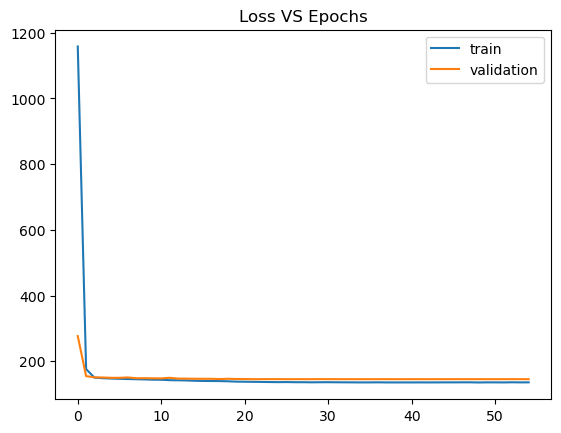

In [153]:
epochs = history_all.epoch
loss = history_all.history["loss"]
val_loss = history_all.history["val_loss"]


plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validation")

plt.legend()
plt.title("Loss VS Epochs")

plt.show()


# conclusion:
## learning curve is smooth after applying batch noormalization & learning rate decay
## deeplearning model is performining better than reandomforest interms of bias and variance. it is less overfit as it is utilising more date
## on an average our predictive model is able to predict delivery time with +/- 9 minutes deviation

# Further enhancements: 
## there are multiple data issues which needs to be fixed to improve model performance further
## need more features which may contribute model performance further.
## multiple features are right skewed and instead of deleteing them as part of outlier elimination, apply log transformation and see model performance further


# Below questions & answers gives better further understanding:
    
## 1. Defining the problem statements and where can this and modifications of this be used?
## Ans: Porter needs predictive model to predict delivery estimation time.
##    this helps to improve user experiance time if deployed it in booking app. 
##    Business also can understand what facters are driving/influnceing the delivery time
##    it can also be used to forcast situations by giving interested input values.
    

## 2. List 3 functions the pandas datetime provides with one line explanation?
## Ans. to_datetime - converts string to date datatype
## datetime.dt.day - gives day of the month
## datetime.dt.dayofweek - gives day of the week

## 3. Short note on datetime, timedelta, time span (period)
## Ans: datetime reffers to perticular time/point
## timedelta reffers to certain moment in time. it dosent have info on when is start and end
## time span- reffers to period when it starts and ends

## 4. Why do we need to check for outliers in our data?
## Ans: outliers are away from data distribution or worngly captured. 
##     model tries to min loss on outlier due ot which normal observations my go wrong
##     due to outlier, loss will increase even when it is good on normal observations and difficult to select right hyperparameters
    
## 5. Name 3 outlier removal methods?
## Ans: 1.use standard deviation
##     2. boxplot, IQR 
##    3. Local outlier factor  

## 6. What classical machine learning methods can we use other than random forest for regression?
## Ans: linear regression,svm,Decesion Tree regressor, & boosting techniques etc

## 7.Why is scaling required for neural networks?
## Ans: if ranges of inputs are large, it may lead to overflow of nodes,explod gradients
##    scaling makes loss funtion symmetric and reaches minima fastly. 
##    it updates graddients at equal steps to all features/directions 
   
## 8. Briefly explain your choice of optimizer?
## Ans: Adam. it has RMSprop and SGD with movementum benfits 

## 9. Which activation function did you use and why?
## hidden layers- relu as it si quiker to compute and makes non linear
## output layer- relu as we expect output to be greate than zero

## 10.Why does a neural network perform well on a large dataset?
## Ans: NN models are non linear and high varaince models .variance can be reduced with ## more data. low bias can be achieved easily with increase in model complexity
    